# Introduction 

### About the competition:
The Tabular Playground Series March 2021 is relatively simpler, beginner-friendly competition which includes primary tabular data to play with and getting a good grasp on fundamentals.
</br> 
This notebook demonstrates a basic pipeline using a neural network with hyper-parameter tuning using Optuna framework. We will also taking a look at visualizaion and some EDA. Finally the notebook concludes the important learnings for the competition/training.

In [1]:
#imports 
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import sklearn.datasets
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna 
import os
#models
import lightgbm as lgb
import xgboost as xgb
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


# Plots
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#ignoring warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')
sub_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv')

In [4]:
train_df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


Seperating training data with features from train_df

In [5]:
cat_features = [f'cat{x}'for x in range(0,19)]
cont_features = [f'cont{x}'for x in range(0,11)]
features = cat_features + cont_features

data = train_df[features]
X_test = test_df[features]
target = train_df['target']

train_data = train_df[features]
train_data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,A,I,A,B,B,BI,A,S,Q,A,...,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,A,I,A,A,E,BI,K,W,AD,F,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,A,K,A,A,E,BI,A,E,BM,L,...,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,A,K,A,C,E,BI,A,Y,AD,F,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
4,A,I,G,B,E,BI,C,G,Q,A,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960


## Part 1 - Automated EDA

In [6]:
#install sweetviz library for automated eda
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 10.2 MB/s 


In [7]:
%%time
#analyzing data using sweetviz (automated EDA)
import sweetviz as sv
data_report = sv.analyze(train_df)
data_report.show_html('Analysis.html')


                                             |          | [  0%]   00:00 -> (? left)

Report Analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
CPU times: user 3min 3s, sys: 7.98 s, total: 3min 11s
Wall time: 3min 11s


In [8]:
from IPython.display import IFrame
IFrame(src = 'Analysis.html',width=1000,height=600)

There are a few conclusions we can make from this EDA:
* No feature contains missing/Null values
* There are 19 categorical features, 11 categorical features and 1 target which takes only two values (true/false or 0/1)
* cat2, cat3, cat4, cat5, cat6 and cat9 has small portion of distinct values(Hypothesis: - which can be encoded as "others" without affecting significant performace)
* The range of continuous variable are relative same which means we don't need to change the distribution of them.

## Part 2 - Training Data Visualization

Let's take a quick look at training data distribution and what can we learn more about them.

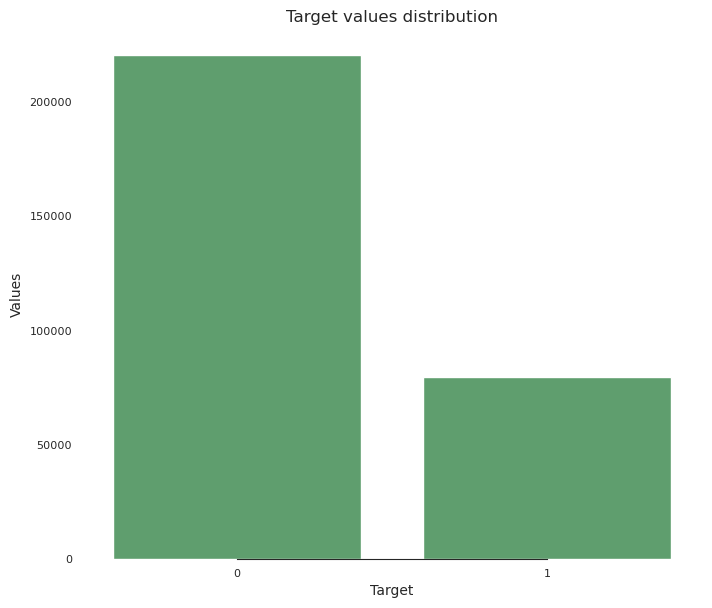

In [9]:
#setting up the platform
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

sns.countplot(target, color="g")
ax.xaxis.grid(False)
ax.set(ylabel="Values")
ax.set(xlabel="Target")
ax.set(title="Target values distribution")
sns.despine(trim=True, left=True)
plt.show()

Comparing train and test data distribution for continuous variables 

<Figure size 600x400 with 0 Axes>

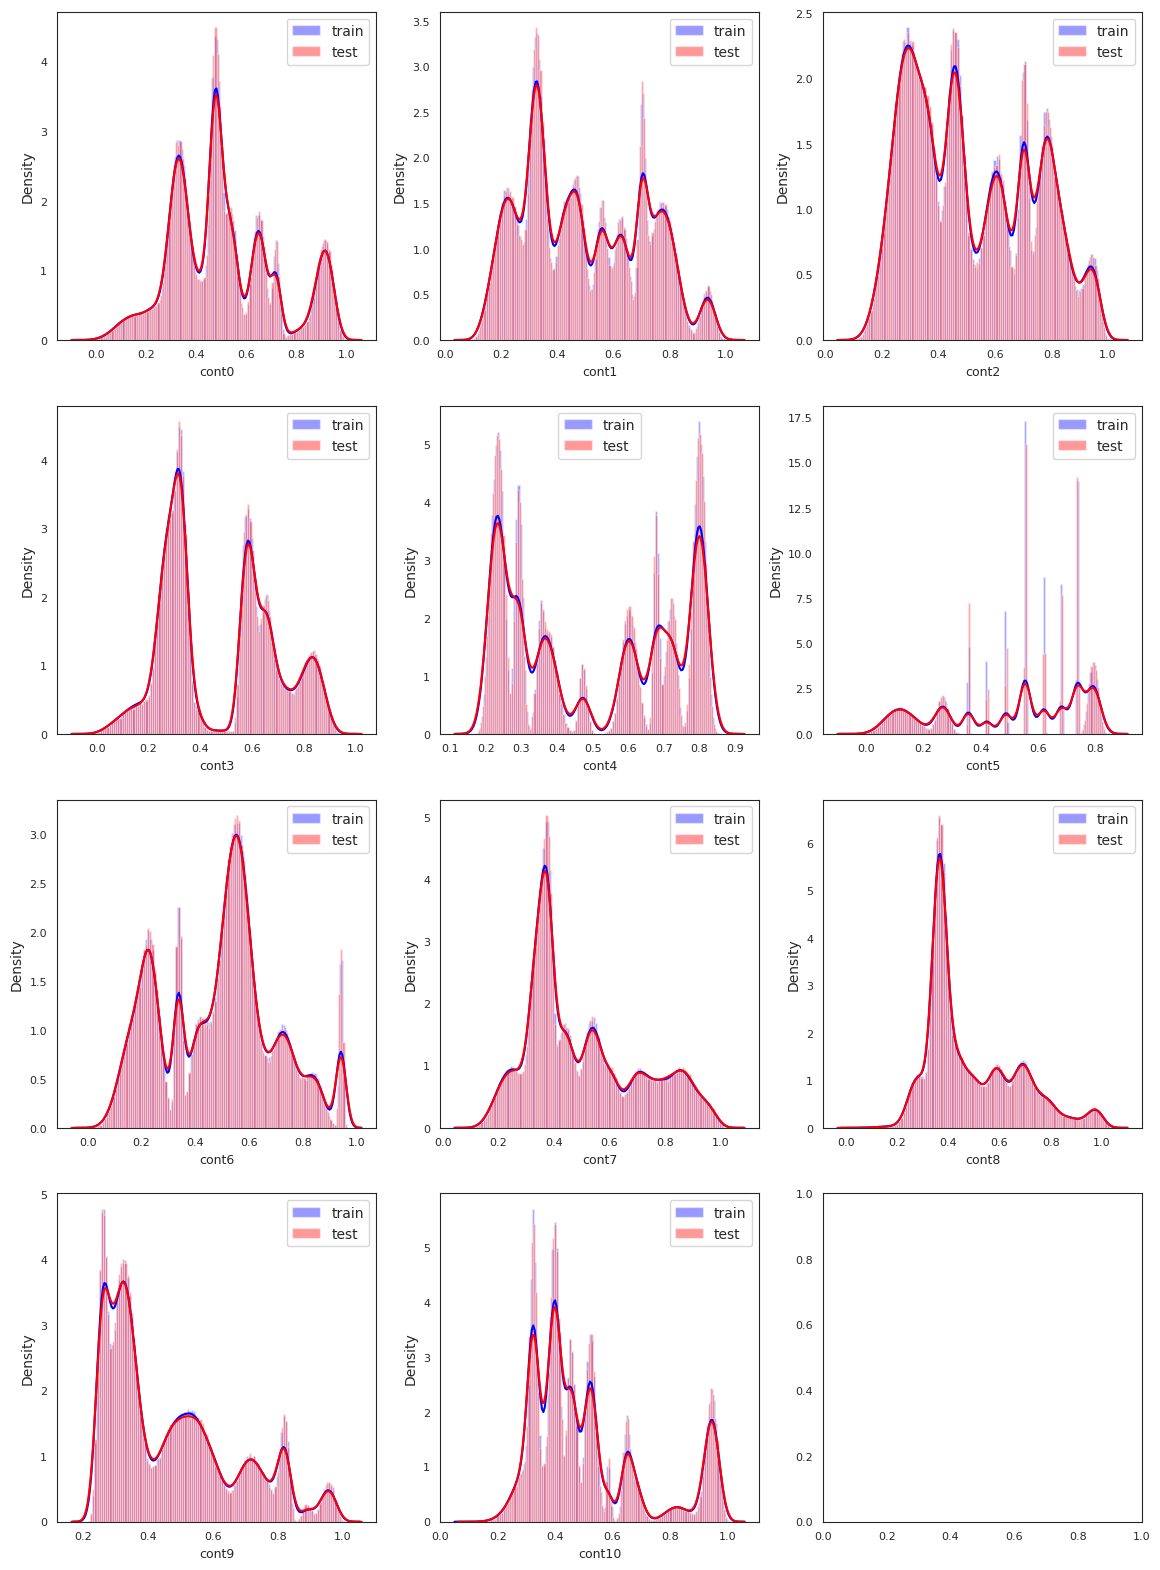

In [10]:

# we will look into the features distribution now, to get insight into the data
plt.figure()
fig, ax = plt.subplots(4, 3,figsize=(14, 20))
for i,feature in enumerate(cont_features):
    plt.subplot(4, 3,i+1)
    sns.distplot(train_data[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(test_df[feature],color="red", kde=True,bins=120, label='test')
    plt.xlabel(feature, fontsize=9); plt.legend()
plt.show()



It seems that the distribution for train and test set matches, meaning the data is sampled from the same distribution which is good for us.

<AxesSubplot:>

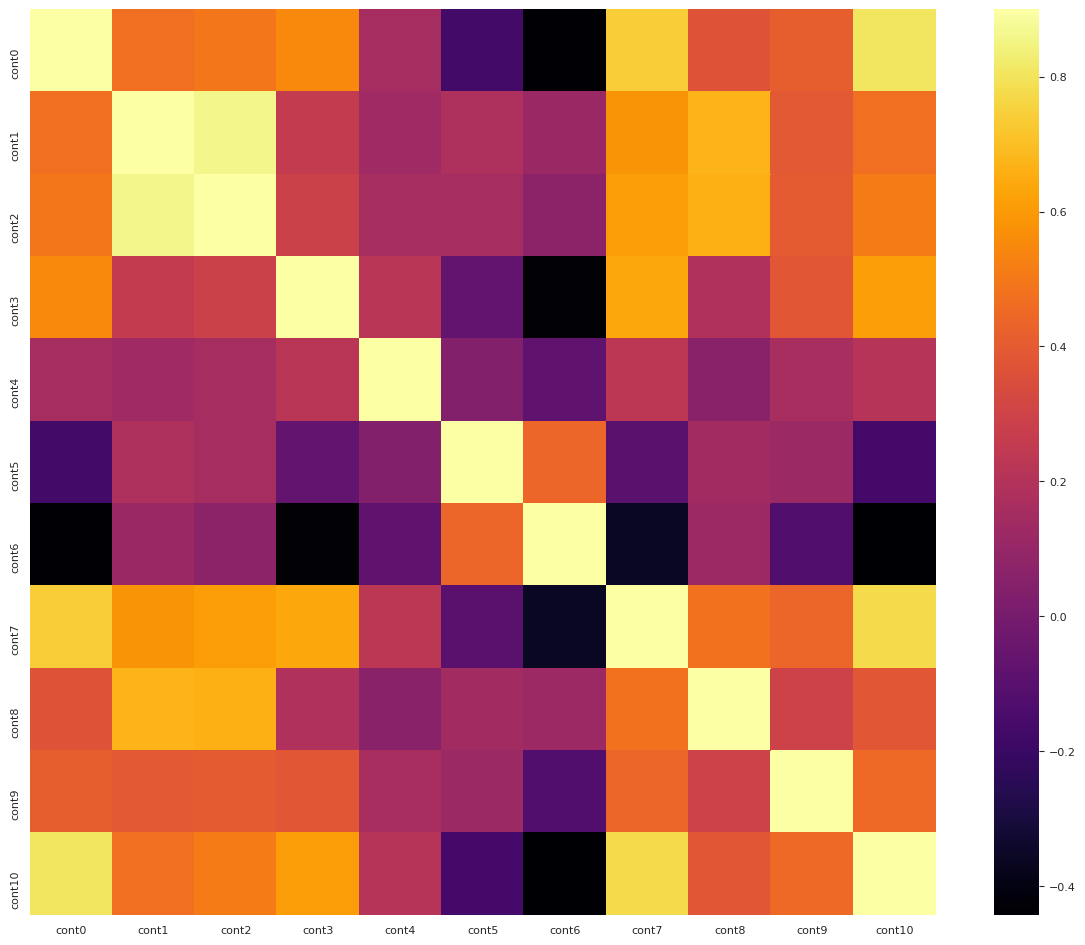

In [11]:
#we will take a look at the correlation of features
corr = train_data.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="inferno", square=True)

## Part 3 - Feature Engineering

First we will remove redundant values in categorical features by applying and filtering others function from values, then we will label encode them to use as numeric features for our training dataset.

In [12]:
#The next portion of code is adapted from this great kernal by andreshg
#https://www.kaggle.com/andreshg/tps-march-a-complete-study

#FE for cat2 var
train_data['cat2'] = train_data['cat2'].apply(lambda x: x if x not in['A', 'C', 'D', 'G', 'F', 'J', 'I', 'M', 'Q', 'L', 'O'] else 'CAT2')
X_test['cat2'] = X_test['cat2'].apply(lambda x: x if x not in['A', 'C', 'D', 'G', 'F', 'J', 'I', 'M', 'Q', 'L', 'O'] else 'CAT2')

# Fix cat5 variable
train_data['cat5'] = train_data['cat5'].apply(lambda x: x if x not in ['N', 'BS', 'BG', 'CA', 'BK', 'T', 'BO', 'CI', 'AY', 'BV'] else 'CAT50')
X_test['cat5'] = X_test['cat5'].apply(lambda x: x if x not in ['BL', 'BJ', 'CK', 'AH', 'I', 'F', 'C', 'AQ', 'AM', 'X'] else 'CAT51')

X_test['cat5'] = X_test['cat5'].apply(lambda x: x if x not in ['N', 'BS', 'BG', 'CA', 'BK', 'T', 'BO', 'CI', 'AY', 'BV'] else 'CAT50')
X_test['cat5'] = X_test['cat5'].apply(lambda x: x if x not in ['BL', 'BJ', 'CK', 'AH', 'I', 'F', 'C', 'AQ', 'AM', 'X'] else 'CAT51')

# Fix cat7 variable
train_df['cat7'] = train_df['cat7'].apply(lambda x: x if x not in ['R', 'AA', 'AY', 'AP', 'O', 'Y'] else 'CAT70')
train_df['cat7'] = train_df['cat7'].apply(lambda x: x if x not in ['AL', 'AD', 'L', 'AC', 'V', 'BA'] else 'CAT71')

X_test['cat7'] = X_test['cat7'].apply(lambda x: x if x not in ['R', 'AA', 'AY', 'AP', 'O', 'Y'] else 'CAT70')
X_test['cat7'] = X_test['cat7'].apply(lambda x: x if x not in ['AL', 'AD', 'L', 'AC', 'V', 'BA'] else 'CAT71')

# Fix cat8 variable
train_df['cat8'] = train_df['cat8'].apply(lambda x: x if x not in ['BC', 'BJ', 'I', 'AW', 'AS'] else 'CAT80')
train_df['cat8'] = train_df['cat8'].apply(lambda x: x if x not in ['AO', 'AG', 'F', 'BD', 'A'] else 'CAT81')

X_test['cat8'] = X_test['cat8'].apply(lambda x: x if x not in ['BC', 'BJ', 'I', 'AW', 'AS'] else 'CAT80')
X_test['cat8'] = X_test['cat8'].apply(lambda x: x if x not in ['AO', 'AG', 'F', 'BD', 'A'] else 'CAT81')

# Fix cat10 variable
train_df['cat10'] = train_df['cat10'].apply(lambda x: x if x not in ['DF', 'IG', 'HJ', 'EK', 'GE', 'LN', 'HB'] else 'CAT10')
train_df['cat10'] = train_df['cat10'].apply(lambda x: x if x not in ['FR', 'JR', 'GI', 'GK', 'MC', 'HC', 'CD'] else 'CAT11')

X_test['cat10'] = X_test['cat10'].apply(lambda x: x if x not in ['DF', 'IG', 'HJ', 'EK', 'GE', 'LN', 'HB'] else 'CAT10')
X_test['cat10'] = X_test['cat10'].apply(lambda x: x if x not in ['FR', 'JR', 'GI', 'GK', 'MC', 'HC', 'CD'] else 'CAT11')

In [13]:
#label encoding for the categorical values
def label_encoder(train_data, test_data, column):
    le = LabelEncoder()
    new_feature = f"{column}_le"
    le.fit(train_data[column].unique().tolist() + test_data[column].unique().tolist())
    
    train_data[new_feature] = le.transform(train_data[column])
    test_data[new_feature] = le.transform(test_data[column])
    
    return new_feature

In [14]:
%%time
#encoding 
EncodedFeatures = [label_encoder(train_data, X_test, feature) for feature in cat_features]
EncodedFeatures

CPU times: user 4.03 s, sys: 10.9 ms, total: 4.04 s
Wall time: 4.04 s


['cat0_le',
 'cat1_le',
 'cat2_le',
 'cat3_le',
 'cat4_le',
 'cat5_le',
 'cat6_le',
 'cat7_le',
 'cat8_le',
 'cat9_le',
 'cat10_le',
 'cat11_le',
 'cat12_le',
 'cat13_le',
 'cat14_le',
 'cat15_le',
 'cat16_le',
 'cat17_le',
 'cat18_le']

We will now make traing dataset from label encoded categorical features + previous continous features, then using train, validation split to train our model and finally evaluate our NN based on validation dataset

In [15]:
Train_features = EncodedFeatures + cont_features
X_train = train_data[Train_features]
X_train.head()

,cat0_le,cat1_le,cat2_le,cat3_le,cat4_le,cat5_le,cat6_le,cat7_le,cat8_le,cat9_le,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,0,8,1,1,1,31,0,46,56,0,...,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,0,8,1,0,4,31,8,50,3,5,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,0,10,1,0,4,31,0,32,38,9,...,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,0,10,1,2,4,31,0,52,3,5,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
4,0,8,1,1,4,31,2,34,56,0,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960


Splitting train-validation data for further evaluation, we will use 5% data as validation data because our training dataset consist of 300,000 values and around 15000 would be enough to evaluate performance.The first step is to create dataset class which further called to make a dataloader(which can make better use of multiprocessing)

In [16]:
#make a class to make dataset
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        ID = self.list_IDs[index]
        # Load data and get label
        X = X_train.loc[ID].to_numpy()
        y = self.labels[ID]

        return X, y

In [17]:
target = train_df['target']
training_set = Dataset(X_train.index, target.values)

def get_data_generators(params):    
    # Load dataset and return train validation split.
    train_size = int(0.95 * len(training_set))
    test_size = len(training_set) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(training_set, [train_size, test_size])

    train_generator = torch.utils.data.DataLoader(train_dataset, **params)
    val_generator = torch.utils.data.DataLoader(val_dataset, **params)
    
    return train_generator, val_generator


### Part 4 - Hyper-parameter Tuning with Optuna
In this section, we will tune our hyperparameters using a optimization framework called Optuna. It works by first creating an objective function which includes defining our model, then another part creates a study where our objective model is sampled using different parameters. Interally, the parameters are first sampled using different samplers to find optimum value from previous studies, then pruners are used to efficiently find parameters that work by prunning non-optimal values. The key to the optimization is providing efficient and fast hyperparameter search with distributed processing, in this notebook we will be using gpu to make search faster for our model parameters.

In [18]:
#define constants 
use_cuda = torch.cuda.is_available()
# DEVICE = torch.device("cuda:0" if use_cuda else "cpu")
#currently we only use CPU
DEVICE = 'cpu'
torch.backends.cudnn.benchmark = True

BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10

params = {'batch_size': BATCHSIZE,
          'shuffle': True,
          'num_workers': 1}
EPOCHS = 10

#make a model Neural Network
def define_model(trial): 
    #Suggest number of layers for our model.
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    #number of input neurons/features
    in_features = 30
    for i in range(n_layers):
        out_features = trial.suggest_int('n_units_l{}'.format(i), 4, 128)
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(torch.nn.ReLU())
        #set dropout for regularization
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))
        in_features = out_features
    
    classes = 1
    layers.append(torch.nn.Linear(in_features, classes))
    layers.append(torch.nn.Sigmoid())
    return torch.nn.Sequential(*layers)


#We will define objective function for actual training during study.
def objective(trial):
    
    # Generate the model.
    model = define_model(trial).to(DEVICE)
     # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    #Splitting into 95-5 train validation data.
    train_loader, valid_loader = get_data_generators(params)
    
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)
            
            #Actual training, propogating loss using optimizer.
            optimizer.zero_grad()
            output = model(data.float())
            msloss = nn.MSELoss()
            loss = msloss(output.float(),target.float())
            loss.backward()
            optimizer.step()
    
    
        # Validation of the model.
        model.eval()
        preds = []
        y_test = []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data.float())
                preds.extend(output.numpy())
                y_test.extend(target.numpy())
        
        preds = np.array(np.array(preds) > 0.5,dtype=int)
        # print("acc", accuracy_score(y_test,preds))
        if len(np.unique(preds)) != 2:
            auc_score = 0
        else:
            auc_score = roc_auc_score(y_test,preds)
        trial.report(auc_score, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    #calculate auc loss
    return auc_score

In [19]:
#ignore debug code 
# Validation of the model.
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# model.eval()
# preds = []
# y_test = []
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(valid_loader):
#         # Limiting validation data.
#         if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
#             break
#         data, target = data.to(DEVICE), target.to(DEVICE)
#         output = model(data.float())
#         preds.append(output.cpu().numpy().reshape((BATCHSIZE,)))
#         y_test.append(target.cpu().numpy())
# print("acc", accuracy_score(y_test,preds))
# auc_score = roc_auc_score(y_test,preds)
# np.array(preds.cpu().numpy(),dtype='float')
# preds = []
# y_test = []
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(valid_loader):
#         # Limiting validation data.
#         if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
#             break
#         data, target = data.to(DEVICE), target.to(DEVICE)
#         output = model(data.float())
#         preds.extend(output.numpy())
#         y_test.extend(target.numpy())
# np.array(np.array(preds) > 0.3,dtype=int).reshape(-1,BATCHSIZE)
# for k,l in valid_loader:
#     data, target = data.to(DEVICE), target.to(DEVICE)
#     output = model(data.float())
    
#     print(output.reshape((BATCHSIZE,)).shape, target.shape)
#     loss = nn.MSELoss()
#     loss_val = loss(output.float(),target.float())
#     loss_val.backward()
#     break
# model(torch.from_numpy(X_train.loc[0].to_numpy()).float())

Creating a study for trials of hyperparameters, we are maximizing the area under ROC curve which is the evaluation measure used in this competition

In [20]:
#Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40, timeout=1000)

[I 2021-03-07 06:04:28,510] A new study created in memory with name: no-name-be610cc4-943b-4e02-bd6b-a55e6c2d7cf4
[I 2021-03-07 06:04:43,003] Trial 0 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 8, 'dropout_l0': 0.2834068541858533, 'n_units_l1': 20, 'dropout_l1': 0.2713656172132497, 'n_units_l2': 36, 'dropout_l2': 0.3924484651128892, 'optimizer': 'Adam', 'lr': 0.003664632944061507}. Best is trial 0 with value: 0.0.
[I 2021-03-07 06:04:57,341] Trial 1 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_l0': 102, 'dropout_l0': 0.29091954470655457, 'optimizer': 'Adam', 'lr': 0.00204119928847202}. Best is trial 0 with value: 0.0.
[I 2021-03-07 06:05:11,882] Trial 2 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 42, 'dropout_l0': 0.3895587677909532, 'n_units_l1': 34, 'dropout_l1': 0.36049746552783274, 'optimizer': 'RMSprop', 'lr': 0.00013247442895568525}. Best is trial 0 with value: 0.0.
[I 2021-03-07 06:05:26,455] Trial 3 fini

In [21]:
print(f"Value of Best trial is: {study.best_trial.value}")
print("Best value Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

Value of Best trial is: 0.5325235109717867
Best value Params: 
    n_layers: 3
    n_units_l0: 43
    dropout_l0: 0.33213640812986595
    n_units_l1: 93
    dropout_l1: 0.4335339079839952
    n_units_l2: 69
    dropout_l2: 0.3610087679542572
    optimizer: SGD
    lr: 8.785642895199805e-05


## Part 5 - Final Model and Final Predictions

We will use best trial parameters from above and train a model on full training data, which we will use for final predictions

In [22]:
#define constants 
use_cuda = torch.cuda.is_available()
# DEVICE = torch.device("cuda:0" if use_cuda else "cpu")
DEVICE = 'cpu'
torch.backends.cudnn.benchmark = True

BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10

params = {'batch_size': BATCHSIZE,
          'shuffle': True,
          'num_workers': 4}
EPOCHS = 10
layers = []
#number of input neurons/features
in_features = 30
for i in range(2):
    out_features = 50
    layers.append(torch.nn.Linear(in_features, out_features))
    layers.append(torch.nn.ReLU())
    #set dropout for regularization
    p = 0.4928102110636615
    layers.append(nn.Dropout(p))
    in_features = out_features

classes = 1
layers.append(torch.nn.Linear(in_features, classes))
layers.append(torch.nn.Sigmoid())
model = torch.nn.Sequential(*layers).to(DEVICE)
lr = 0.001879813193722479
optimizer = getattr(optim, 'Adam')(model.parameters(), lr=lr)
    
train_generator = torch.utils.data.DataLoader(training_set, **params)


# Training of the model.
for epoch in range(50):
    print(f"Epoch no: {epoch}")
    model.train()
    for batch_idx, (data, target) in enumerate(train_generator):
        # Limiting training data for faster epochs.
        if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            break

        data, target = data.to(DEVICE), target.to(DEVICE)

        #Actual training, propogating loss using optimizer.
        optimizer.zero_grad()
        output = model(data.float())
        msloss = nn.MSELoss()
        loss = msloss(output.float(),target.float())
#         print(loss)
        loss.backward()
        optimizer.step()

#we won't be validating this model as we already know this is best from above and use this to train on full data

Epoch no: 0
Epoch no: 1
Epoch no: 2
Epoch no: 3
Epoch no: 4
Epoch no: 5
Epoch no: 6
Epoch no: 7
Epoch no: 8
Epoch no: 9
Epoch no: 10
Epoch no: 11
Epoch no: 12
Epoch no: 13
Epoch no: 14
Epoch no: 15
Epoch no: 16
Epoch no: 17
Epoch no: 18
Epoch no: 19
Epoch no: 20
Epoch no: 21
Epoch no: 22
Epoch no: 23
Epoch no: 24
Epoch no: 25
Epoch no: 26
Epoch no: 27
Epoch no: 28
Epoch no: 29
Epoch no: 30
Epoch no: 31
Epoch no: 32
Epoch no: 33
Epoch no: 34
Epoch no: 35
Epoch no: 36
Epoch no: 37
Epoch no: 38
Epoch no: 39
Epoch no: 40
Epoch no: 41
Epoch no: 42
Epoch no: 43
Epoch no: 44
Epoch no: 45
Epoch no: 46
Epoch no: 47
Epoch no: 48
Epoch no: 49


**Note**:
This is only proof of concept for finding optimized hyperparameters of a neural network, your values of best trial may differ from those of here due to inherent non-determinism. Trying for more number of trials is one of the best way to find best_trial which are optimized. 

In [23]:
#predictions

with torch.no_grad():
    test_data = X_test[Train_features].to_numpy()
    predictions = model(torch.from_numpy(test_data).float())
    final_preds = (np.concatenate(predictions.numpy()) > 0.3).astype(int)
    sub_df['target'] = predictions.numpy()
    sub_df.to_csv('FinalSubmission.csv')

## Part 6 - Conclusion

Although Neural Networks are very powerful when it comes to retaining complexity of data and learning non-linear functions from the internal patterns of training data, it is prone to overfitting and we cann't see much deeper inside of it. It's like blackbox which is very powerful yet unknown from inside. But it doesn't prevent us to make better use of it. In this notebook we have demonstrated the concept of hyperparameter optimization using optuna which can be further used to find best model for training data given the evaluation metric. If you find this notebook interesting, don't forget to upvote and give your feedback down below. Thanks for reading and your valuable time!!